# In this notebook, we describe our neural collaborative filtering model. 

Note that the model did not work particularly well. 

We attempted to develop a model that used a feedforward neural network to predict responses, but did not significantly improve on the baselines. 

## Overall Structure

The model combines a language model with a participant model to provide latent embeddings for each participant and question. These embeddings are then fed into an MLP which outputs parameters for a response model. We experimented with a few variants for each of the language model and response model. 

## Participant Model
The participants were represented with their `user_id`, which was a unique integer for each user. Since we had no user features, we used a learned embedding which took this to a $u$-dimensional space. 

## Language Model
The questions were each assigned a `item_id` which was a unique integer for each item. We also had access to the text of the question itself. We experimented with a learned embedding from the `item_id`, throwing away the semantic information in the question text; we also tried using the average of the word2vec representations of each of the words in the question; we also used an RNN-based model which was initially trained unsupervised on the question corpus and fine-tuned on the predicting slow judgments task.

In practice we found that there was not very much difference between the embedding, word-vector and RNN model. We did not include the RNN model in the final version of the model. For the politifact game we found that the model could do just as well without a representation of the question at all, doing just as well with just the metadata.

## Metadata Model
For the politifact dataset we also had some additional data: some metadata such as the encoded identity of the speaker, the occupation of the speaker, etc, the context of their statement, etc. We pre-encoded this as a series of one-hot vectors, giving us a 260-dimensional representation of the metadata. We fed this into a linear layer which mapped this to a latent representation of the metadata.
We have a choice when we load the metadata. It's stored on disk as a series of text fields. We can load it as a numeric pytorch tensor in a compressed or full format. Some of the fields have many different possible values, e.g. 'job'. In full format this is one-hot encoded, while in the limited format some of the these fields are represented by their word2vec representation instead. The metadata model consisted of a linear layer which mapped this to a latent embedding of dimension \(v\).

The metadata latent embedding was concatenated with the language latent embedding to give an overall question representation of size $2v$. If the language model was not included then the overall qustion representation was of size $v$.

## Parameter Model

This section of the model took in the concatenation of the participant, language and metadata latent features ($(u+2v)$-dimensional if language model was used, $(u + v)$-dimensional if just metadata was used for the question), and returned the parameters of the response model. 

## Response Model

This governed how the model made predictions of the user's response on the question. We tried two models. One assumed a linear response, taking in the slope and intercept for the line (`LinRegress`). Another directly used the output of the parameter model as the predicted response (`OnlyMLP`). In theory the first model would be more sample-efficient, able to make inferences from slow and fast responses to predict medium responses, while the second model would have to learn the relationship between the different time-points' predictions (though could learn a nonlinear relation if it had enough data).

Both models can augmented with a softmax on the final layer, such that predictions in $[-\infty, \infty]$ get mapped to $[0, 1]$. Without the softmax, the model's predictions are clamped at $0.02$ and $0.98$. We found that the softmax doesn't hugely improve the performance of the model, though  it's not clear why this is. 

## Regularization and Overfitting
We found that our model quickly overfitted to the training set and gave bad performance on the validation set. However, when we aggressively regularized, the model collapsed to predicting 0.5 for all users and items. We were able to simplify the model by reducing the size of the latent embeddings, cutting the number of hidden layers, and in the case of politifact removing the language model (relying only on the metadata). 

### Animation

To help debugging, we built the capability to plot an animation of the progress of the model's training. This wasn't tested extensively, but might be useful to see what's happening inside the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import argparse
import torch
import os
from src.models.content_aware.strip_temporal_cf import StripTemporalCF, CompiledStripTemporalCF
from src.models.content_aware.sampler import SubsetDeterministicSampler
from torch.utils.data.sampler import SubsetRandomSampler
from data.load_from_csv import get_content_datasets
import definitions

In [2]:
def run_temporal_cf(task,
                    sparsity,
                    num_epochs,
                    batch_size=64,
                    learning_rate=1e-3,
                    weight_decay=1e-3,
                    l1_coef=0.,
                    include_q_embed=True,
                    use_metadata=True,
                    user_embed_size=1,
                    language_embed_dim=1,
                    time_model_string='LinRegress',
                    time_ordinal=True,
                    language_model_string='embedding',
                    latent_to_params_hidden_dims=[32, 32],
                    use_cuda=False,
                    softmax=True,
                    temperature=10,
                    animate=False,
                    weight=[1, 1, 1],
                    seed=0,
                    optimizer='SGD',
                    verbose=True,
                    patience=20,
                    schedule_epochs=[50],
                    schedule_reductions=[5],
                    writeout=False,
                    full_metadata=False,
                    print_test_accuracy=False):
    
    """This runs our neural collaborative filtering model. The arguments are as follows:
    task: Either  'politifact' or 'fermi'
    sparsity: Either 'unmasked', 'light', or 'heavy'
    num_epochs: Number of epochs to train for
    batch_size: Train and test batch size
    learning_rate: Optimiser learning rate
    weight_decay: Amount of L2 regularization to put on the parameters
    l1_coef: Amount of L1 regularization to put on the parameters
    include_q_embed: Whether to include a question embedding. Required for Fermi
    use_metadata: Whether to use the metadata features. Won't work for Fermi
    user_embed_size: Size of the embedding latent dimension for users
    langauge_embed_dim: Size of the embedding latent dimension for questions
    time_model_string: Either 'LinRegress' or 'OnlyMLP'. Time model
    time_ordinal: Whether to treat the times as the actual times or [1, 2, 3]
    language_model_string: Either 'Embedding' or 'avg'
    latent_to_params_hidden_dims: Number of neurons in each hidden layer
    use_cuda: Whether to use cuda
    softmax: Whether to use a softmax on the output to put it into (0, 1)
    temperature: Temperature to use in the softmax
    animate: Whether to generate an animation with useful debug information. Takes longer to run
    weight: Weights assigned to the [fast, medium, slow] judgments in the loss summand
    seed: Random seed
    optimizer: Optimizer to use. Can be 'SGD', 'Adam', etc
    verbose: Whether to print debug information
    patience: Number of epochs with increasing validation loss before early stopping
    schedule_epochs: Epochs where the learning rate decreases by the corresponding factor in schedule_reductions
    schedule_reductions: Factors to decrease the learning rate by
    writeout: If we save the results and predictions to disk
    full_metadata: Whether the metadata representation is fully one-hot, i.e. it has a one-hot representation
                    for each field, or whether it uses word-vector representations for some fields
    print_test_accuracy: Print accuracy on the holdout test set
    """
    
    torch.manual_seed(seed)
    saved_args = locals()
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        

    #########################
    ######## DATASET ########
    #########################

    # TODO: to fix to new loader
    train_dataset, val_dataset, test_dataset = get_content_datasets(task, sparsity, full_detail=full_metadata)

    # We need to get all the ids so that we can make embeddings
    all_user_ids = np.concatenate([train_dataset.user_ids,
                                   val_dataset.user_ids,
                                   test_dataset.user_ids])
    num_users = int(max(all_user_ids) + 1)
    metadata_size = int(train_dataset.metadata_size)

    # We need to build a question -> iid dictionary
    # If we want to use a question text embedding
    # item_texts are {id: text}, we first invert and then combine
    if language_model_string == 'embedding':
        inv_train_texts = {v: k for k, v in train_dataset.item_text.items()}
        inv_val_texts = {v: k for k, v in val_dataset.item_text.items()}
        inv_test_texts = {v: k for k, v in test_dataset.item_text.items()}
        question_map_dict = {**inv_train_texts, **inv_val_texts, **inv_test_texts}
    else:
        question_map_dict = None

    ################################
    ######## BUILD MODEL ########
    ################################

    model = StripTemporalCF(language_model_string, latent_to_params_hidden_dims,
                            time_model_string, task, use_metadata, time_ordinal,
                            int(language_embed_dim), softmax, metadata_size, int(num_users),
                            int(user_embed_size), include_q_embed, question_map_dict, temperature)
    ######## COMPILE MODEL ########
    ################################
    optim_params = {'lr': learning_rate, 'weight_decay': weight_decay}
    compiled_model = CompiledStripTemporalCF(model, weight=weight, num_epochs=num_epochs,
                                        batch_size=batch_size, use_cuda=use_cuda,
                                        optim_params=optim_params,
                                        l1_coef=l1_coef, optimizer=optimizer)

    ################################
    ######## FIT MODEL ########
    ################################
    train_idx = np.arange(len(train_dataset.ratings))
    val_idx = np.arange(len(val_dataset.ratings))

    train_loss, mse_val_loss, time = compiled_model.fit(train_dataset,
                                                                      SubsetRandomSampler(train_idx), 
                                                                      val_dataset, 
                                                                      SubsetDeterministicSampler(val_idx),
                                                                      verbose, 
                                                                      patience=patience, animate=animate,
                                                                      schedule_epochs=schedule_epochs[:],
                                                                      schedule_reductions=schedule_reductions[:])

    print('at this line now')
    ################################
    ######## TEST MODEL ########
    ################################
    test_idx = np.arange(len(test_dataset.ratings))
    test_mse_loss, test_preds, test_ratings, _, _ = compiled_model.validate(test_dataset,
                                                                          SubsetDeterministicSampler(
                                                                              test_idx))
    if print_test_accuracy:
        print("Test loss was {}".format(test_mse_loss))
    


    ################################
    ######## CALIBRATE MODEL #######
    ################################

    label_string = ' '.join(['{}: {} '.format(u, v) for u, v in saved_args.items()])
    train_results = compiled_model.validate(train_dataset, SubsetDeterministicSampler(train_idx))
    #av_val_bce_loss, av_val_mse_loss, masked_preds, masked_ratings, masked_weights, list(zipped_responses)
    _, train_preds, train_ratings, _, train_responses = train_results
    calibration_plot(train_ratings.data, train_preds.data, jitter=True, label_string=label_string + 'train')

    val_results = compiled_model.validate(val_dataset, SubsetDeterministicSampler(val_idx))
    #av_val_bce_loss, av_val_mse_loss, masked_preds, masked_ratings, masked_weights, list(zipped_responses)
    _, val_preds, val_ratings, _, val_responses = val_results
    calibration_plot(val_ratings.data, val_preds.data, jitter=True, label_string=label_string + 'val')

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, figsize=(12, 6))
    axes.plot(train_loss, c='b', label='Train loss')
    axes.plot(mse_val_loss, c='r', ls='--', label='Val MSE')
    axes.plot([best_baseline(task, sparsity)] * len(mse_val_loss), c='g', ls='--', label='Best baseline val MSE')    
    axes.set_ylim([0.09, 0.15])

    axes.legend()
    axes.set_xlabel('Epoch')
    import textwrap    
    title_wrapped_str = '\n'.join(textwrap.wrap(label_string, 140))
    title = axes.set_title(title_wrapped_str, fontsize=8)
    #fig.tight_layout()
    title.set_y(1.05)
    fig.subplots_adjust(top=0.8)
    #fig.savefig()
    


    ################################
    ######## PRINT/SAVE RESULTS ########
    ################################
    if writeout:
        directory = definitions.RESULTS_DIR
        save_output_filename = 'resulto'
        if not os.path.exists(os.path.join(directory, save_output_filename)):
            os.makedirs(os.path.join(directory, save_output_filename))
        if verbose:
            print("saving output to: {}".format(
                os.path.join(directory, save_output_filename)))
        with open(os.path.join(directory, save_output_filename) + "/train_loss.txt", "wb") as f:
            np.savetxt(f, np.array(train_loss))
        with open(os.path.join(directory, save_output_filename) + "/mse_val_loss.txt", "wb") as f:
            np.savetxt(f, np.array(mse_val_loss))
        with open(os.path.join(directory, save_output_filename) + "/time.txt", "wb") as f:
            np.savetxt(f, np.array(time))
                
                
    return train_loss, mse_val_loss, test_mse_loss


In [3]:
def best_baseline(task, sparsity):
    """Returns the best baseline (SVD) for the given task
       and sparsity"""
    results_dict = {('politifact', 'unmasked'): 0.12397,
                    ('politifact', 'light'): 0.1332,
                    ('politifact', 'heavy'): 0.117,
                    ('fermi', 'unmasked'): 0.1186,
                    ('fermi', 'light'): 0.1200,
                    ('fermi', 'heavy'): 0.1144
                   }
    return results_dict[(task, sparsity)]

In [4]:
def calibration_plot(targets, predictions, weights=None, alpha=0.5, jitter=False, label_string=''):
    import textwrap
    fig, axes = plt.subplots(1, figsize=(12, 6))
    if jitter:
        targets += torch.FloatTensor(np.random.normal(0, 0.005, size=len(targets)))
    axes.scatter(targets, predictions, alpha=alpha)
    axes.set_xlabel('Ground truth')
    axes.set_ylabel('Prediction')
    axes.set_xlim([-0.1, 1.1])
    axes.set_ylim([-0.1, 1.1])
    title_wrapped_str = '\n'.join(textwrap.wrap(label_string, 140))
    title = axes.set_title(title_wrapped_str, fontsize=8)
    #fig.tight_layout()
    title.set_y(1.05)
    fig.subplots_adjust(top=0.8)
    import time
#    fig.savefig('/Users/Chris/Documents/Oxford/new-psj/psj/results/cal_plot_{}.png'.format(str(time.time()).split('.')[0]),
#dpi=500, pad_inches=0.0)

## Some illustrative runs with different parameters

Loading w2v dict
Loaded Word2Vec dict: 26.03s
Number of words in corpus: 400001
Stopping at epoch 109
at this line now


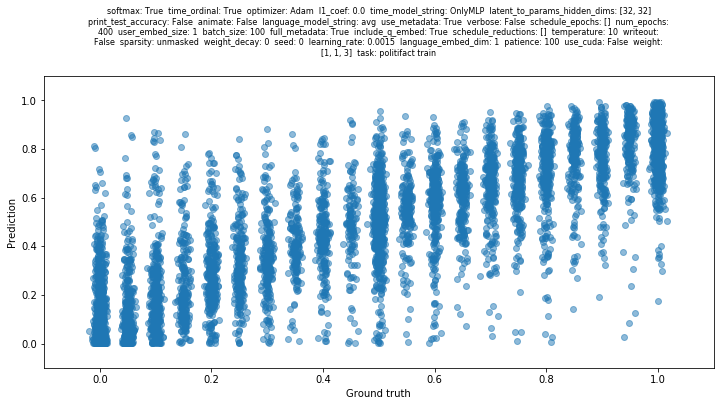

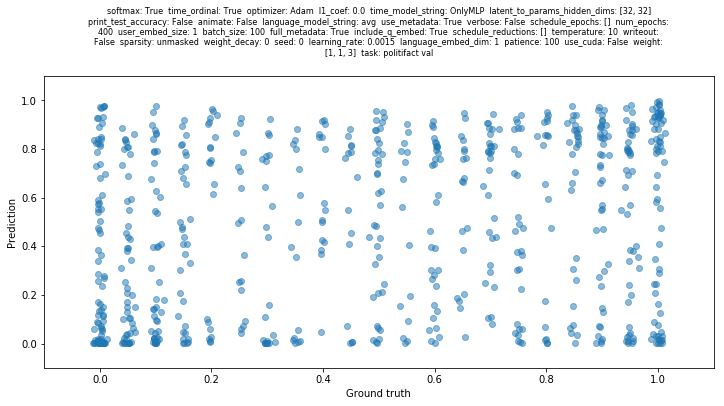

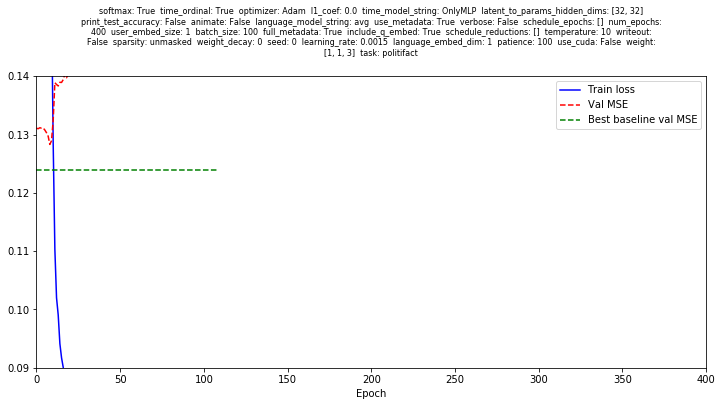

In [5]:
# Standard parameters, no weight decay, MLP time-series model, and a softmax on the output. 
# As we can see, the model quickly overfits to the train set and starts to get worse validation performance
# 

trains, tests, _ = run_temporal_cf('politifact', 'unmasked', 400, verbose=False,
                                   learning_rate=1.5e-3, weight_decay=0, patience=100,
                                  batch_size=100, time_ordinal=True, optimizer='Adam',
                                  softmax=True, time_model_string='OnlyMLP', latent_to_params_hidden_dims=[32, 32],
                                  language_model_string='avg', include_q_embed=True, use_metadata=True, 
                                  schedule_epochs=[], schedule_reductions=[], full_metadata=True, weight=[1,1,3])
plt.xlim([0, 400])
plt.ylim([0.09, 0.14])
plt.show()

Loading w2v dict
Loaded Word2Vec dict: 18.88s
Number of words in corpus: 400001
Stopping at epoch 266
at this line now


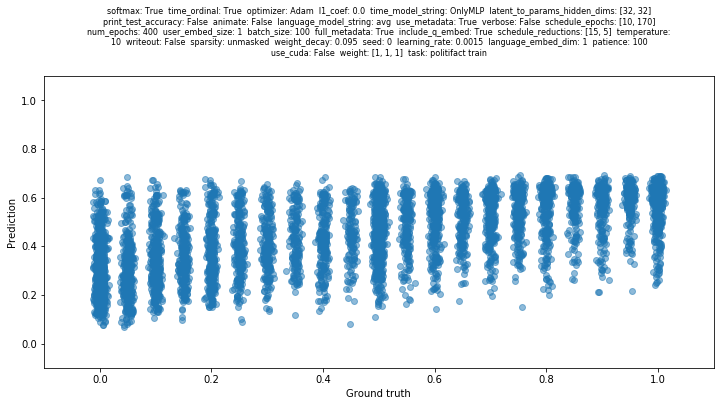

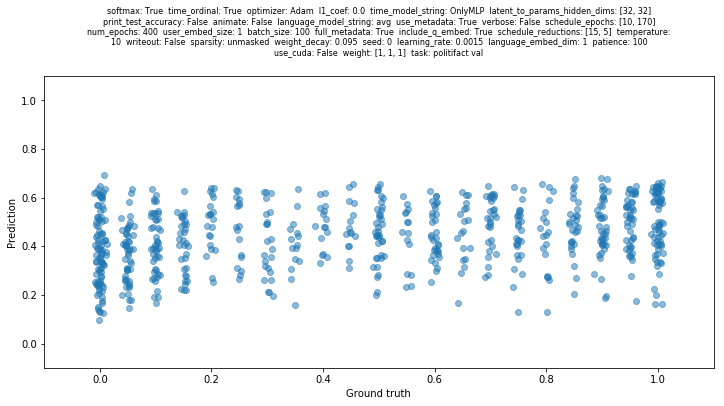

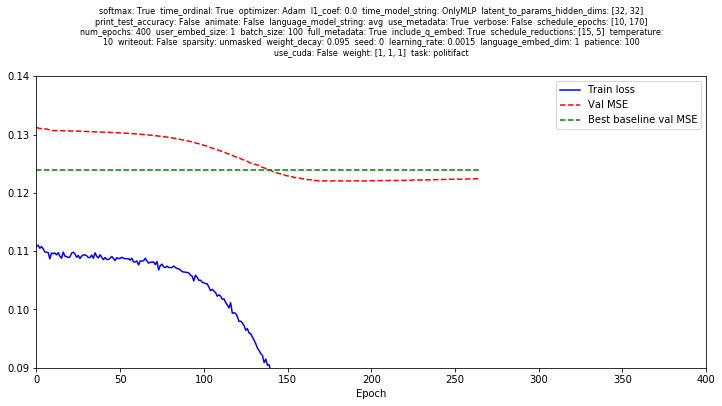

In [6]:
# We fix up a couple of the parameters and increase the regularization, add in learning 
# rate scheduling

trains, tests, _ = run_temporal_cf('politifact', 'unmasked', 400, verbose=False,
                                   learning_rate=1.5e-3, weight_decay=0.095, patience=100,
                                  batch_size=100, time_ordinal=True, optimizer='Adam',
                                  softmax=True, time_model_string='OnlyMLP', latent_to_params_hidden_dims=[32, 32],
                                  language_model_string='avg', include_q_embed=True, use_metadata=True, 
                                  schedule_epochs=[10, 170], schedule_reductions=[15, 5], full_metadata=True)
plt.xlim([0, 400])
plt.ylim([0.09, 0.14])
plt.show()